# Implement a tiny version of YOLO with DIOR dataset

## Import libraries

In [1]:
import os
import shutil
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/arch/ObjDct_Repo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Implement YOLO architecture

In [2]:
class TinyYOLOv1(nn.Module):
    def __init__(self, B=2, num_classes=1):
        super(TinyYOLOv1, self).__init__()
        S = 7  # grid size
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.square_activation1 = SquareActivation()
        self.batch_norm1 = nn.BatchNorm2d(8)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.square_activation2 = SquareActivation()
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4096, 2048)
        self.square_activation_ft = SquareActivation()
        self.fc2 = nn.Linear(2048, S * S * (B * 3 + num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.square_activation1(x)
        x = self.batch_norm1(x)
        x = self.avgpool1(x)
        
        x = self.conv2(x)
        x = self.square_activation2(x)
        x = self.batch_norm2(x)
        x = self.avgpool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.square_activation_ft(x)
        x = self.fc2(x)
        return x

# Assuming the SquareActivation is defined somewhere else
class SquareActivation(nn.Module):
    def forward(self, x):
        return x * x

model = TinyYOLOv1()
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
TinyYOLOv1                               [1, 441]                  --
├─Conv2d: 1-1                            [1, 8, 128, 128]          224
├─SquareActivation: 1-2                  [1, 8, 128, 128]          --
├─BatchNorm2d: 1-3                       [1, 8, 128, 128]          16
├─AvgPool2d: 1-4                         [1, 8, 64, 64]            --
├─Conv2d: 1-5                            [1, 16, 32, 32]           1,168
├─SquareActivation: 1-6                  [1, 16, 32, 32]           --
├─BatchNorm2d: 1-7                       [1, 16, 32, 32]           32
├─AvgPool2d: 1-8                         [1, 16, 16, 16]           --
├─Flatten: 1-9                           [1, 4096]                 --
├─Linear: 1-10                           [1, 2048]                 8,390,656
├─SquareActivation: 1-11                 [1, 2048]                 --
├─Linear: 1-12                           [1, 441]                  903,609

## Utility Function

### Distance between centers

In [3]:
def euclidean_distance(center_preds, center_labels):
    """
    Calculate euclidean distance
    Parameters:
        center_preds: predictions of centers (BATCH_SIZE, 2)
        center_labels: target of centers of shape (BATCH_SIZE, 2)
    Returns:
        distance: euclidean distance for all examples
    """

    x1 = center_preds[..., 0:1]
    y1 = center_preds[..., 1:2]
    x2 = center_labels[..., 0:1]
    y2 = center_labels[..., 1:2]

    distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

### Mean Average Distance

In [4]:

def mean_average_distance(
    pred_centers, true_centers, distance_threshold=0.1
):
    """
    Calculate mean average distance

    Parameters:
        pred_centers (list): Predictions of centers [train_idx, class_prediction, prob_score, x, y]
        true_centers (list): Target of centers
        distance_threshold (float): Threshold to consider a prediction correct

    Returns:
        float: Mean average distance for all examples
    """

    total_true_centers = len(true_centers)

    if total_true_centers == 0:
        return 0

    total_distances = 0

    for true_center in true_centers:
        nearest_distance = float('inf')

        for pred_center in pred_centers:
            # Check if the prediction belongs to the same object (train_idx)
            if pred_center[0] == true_center[0]:
                # Compute Euclidean distance between the predicted center and the ground truth center
                distance = torch.dist(torch.tensor(true_center[3:]), torch.tensor(pred_center[3:]))
                
                # Update nearest distance if current distance is smaller
                if distance < nearest_distance:
                    nearest_distance = distance

        # Add the nearest distance to the total if it's within the threshold
        if nearest_distance <= distance_threshold:
            total_distances += nearest_distance

    # Calculate the mean average distance
    mean_average_distance = total_distances / total_true_centers
    
    return mean_average_distance


### Mean Average Precision

In [5]:
def accuracy_precision(pred_centers, target_boxes):
    """
    Parameters:
        pred_centers: list of predicted centers [train_idx, class_prediction, prob_score, x, y]
        target_boxes: list of target boxes [train_idx, class, x, y, w, h]
    Returns:
        mAP: mean average precision, where TP is a center that is inside the target boxes
    """
    total_true_positives = 0
    total_predictions = len(pred_centers)
    total_true_boxes = len(target_boxes)
    for pred_center in pred_centers:
        train_idx, class_prediction, _, x_pred, y_pred = pred_center

        for target_box in target_boxes:
            train_idx_target, class_target, x_target, y_target, w_target, h_target = target_box

            if train_idx == train_idx_target and class_prediction == class_target:
                if x_pred >= x_target and x_pred <= x_target + w_target and y_pred >= y_target and y_pred <= y_target + h_target:
                    total_true_positives += 1
                    break

    accuracy_score = total_true_positives / total_predictions if total_predictions > 0 else 0
    precision_score = total_true_positives / total_true_boxes if total_true_boxes > 0 else 0
    return accuracy_score, precision_score

### Non Max Suppression


In [6]:
def non_max_suppression(centers, threshold):

    assert type(centers) == list
    centers = [center for center in centers if center[1]>threshold]
    centers_after_nms = sorted(centers, key=lambda x: x[1], reverse=True)    
    return centers_after_nms


### Get and convert centers

In [7]:
def get_bboxes(
    loader,
    model,
    threshold,
    device="cuda",
):
    all_pred_centers = []
    all_true_centers = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels, boxes_list) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            predictions = model(x)

        
        batch_size = x.shape[0]
        true_centers = cellcenters_to_centers(labels) # type: ignore
        pred_centers = cellcenters_to_centers(predictions) # type: ignore
        
        

        for idx in range(batch_size):

            boxes = boxes_list[idx].to(device)

            nms_centers= non_max_suppression(
                pred_centers[idx],
                threshold=threshold,
            )

            for center in nms_centers:
                all_pred_centers.append([train_idx] + center)

            for center in true_centers[idx]:
                if center[1] > 0:
                    all_true_centers.append([train_idx] + center)

            for box in boxes:
                all_true_boxes.append([train_idx] + box.tolist())

            train_idx += 1

    model.train()
    return all_pred_centers, all_true_centers, all_true_boxes


In [8]:
def convert_cellcenters(predictions, S=7, C=3):
    """
    Converts predictions from the model to centers
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 6)

    centers1 = predictions[..., C + 1:C + 3]
    centers2 = predictions[..., C + 4:C + 6]
    
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 3].unsqueeze(0)), dim=0
    )
    best_center = scores.argmax(0).unsqueeze(-1)

    best_centers = centers1 * (1 - best_center) + best_center * centers2

    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_centers[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_centers[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    converted_centers = torch.cat((x, y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 3]).unsqueeze(
        -1
    )
    
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_centers), dim=-1
    )

    return converted_preds

In [9]:
def cellcenters_to_centers(out, S=7):
    converted_pred = convert_cellcenters(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_centers = []

    for ex_idx in range(out.shape[0]):
        centers = []
        for center_idx in range(S * S):
            centers.append([x.item() for x in converted_pred[ex_idx, center_idx, :]])
        all_centers.append(centers)
        
    return all_centers

## Create Loader of Dataset

In [10]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, centers):
        for t in self.transforms:
            img, centers = t(img), centers

        return img, centers


transform = Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

In [11]:
class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=7, B=2, C=3, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        centers = []
        boxes = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                centers.append([class_label, x, y])
                boxes.append([class_label, x, y, width, height])
        
        boxes = torch.tensor(boxes)
        #boxes = [torch.tensor(box) for box in boxes]
        centers = torch.tensor(centers)        
        if self.transform:
            image, centers = self.transform(image, centers)
        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 3 * self.B))
        for center in centers:
            class_label, x, y = center
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                center_coordinates = torch.tensor(
                    [x_cell, y_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 3] = center_coordinates
                label_matrix[i, j, class_label] = 1
    
        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix , boxes

## YOLO Loss

From original paper: 
>   YOLO predicts multiple bounding boxes per grid cell. At training time we only want one bounding box predictor to be responsible for each object. We assign one predictor to be “responsible” for predicting an object based on which prediction has the highest current IOU with the ground truth. This leads to specialization between the bounding box predictors.
Each predictor gets better at predicting certain sizes, aspect ratios, or classes of object, improving overall recall. 

$$
\begin{gathered}
\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_i-\hat{x}_i\right)^2+\left(y_i-\hat{y}_i\right)^2\right] \\
+\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2\right] \\
+\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left(C_i-\hat{C}_i\right)^2 \\
+\lambda_{\text {noobj }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {noobj }}\left(C_i-\hat{C}_i\right)^2 \\
+\sum_{i=0}^{S^2} \mathbb{1}_i^{\text {obj }} \sum_{c \in \text { classes }}\left(p_i(c)-\hat{p}_i(c)\right)^2
\end{gathered}
$$

During training we optimize the following, multi-part where $ 1_{obj}^i $ denotes if object appears in cell **i** and $1_{obj}^{ij}$ denotes that the **j**  bounding box predictor in cell i is “responsible” for that prediction.

In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects. This can lead to model instability, as the model may prioritize learning to predict empty cells rather than focusing on correctly detecting objects in cells containing them, causing training to diverge early on. To remedy this, we increase the loss from bounding box coordinate predictions and decrease the loss from confidence predictions for boxes that don’t contain objects. We use two parameters, $\lambda_{coord}$ and $\lambda_{noobj}$  to accomplish this.

Note that the loss function only penalizes classification error if an object is present in that grid cell (hence the conditional class probability discussed earlier). It also only penalizes bounding box coordinate error if that predictor is “responsible” for the ground truth box (i.e. has the highest
IOU of any predictor in that grid cell).

In [12]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*3) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 3)
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_c1 = euclidean_distance(predictions[..., self.C + 1:self.C + 3], target[..., self.C + 1:self.C + 3])
        iou_c2 = euclidean_distance(predictions[..., self.C + 4:self.C + 6], target[..., self.C + 1:self.C + 3])
        ious = torch.cat([iou_c1.unsqueeze(0), iou_c2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestcenter = torch.max(ious, dim=0)
        exists_center = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i
        
        # ======================== #
        #   FOR CENTER COORDINATES #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.

        center_predictions = exists_center * (
            (
                bestcenter * predictions[..., self.C + 4:self.C + 6]
                + (1 - bestcenter) * predictions[..., self.C + 1:self.C + 3]
            )
        )
        center_targets = exists_center * target[..., self.C + 1:self.C + 3]

        center_loss = self.mse(
            torch.flatten(center_predictions, end_dim=-2),
            torch.flatten(center_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_center = (
            bestcenter * predictions[..., self.C + 3:self.C + 4] + (1 - bestcenter) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_center * pred_center),
            torch.flatten(exists_center * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C + 3:self.C + 4], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_center * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_center * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * center_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Training

In [13]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 50
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [14]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y,boxes) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

### Combine all

In [15]:
def collate_fn(batch):
    images = []
    label_matrices = []
    boxes_list = []
    for item in batch:
        images.append(item[0])
        label_matrices.append(item[1])
        boxes_list.append(item[2])
    images = torch.stack(images)
    label_matrices = torch.stack(label_matrices)
    return images, label_matrices, boxes_list

In [16]:
files_dir = 'three_class_dataset'
model = TinyYOLOv1().to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()


train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
)


In [52]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn)
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        train_loader, model, threshold=0.5
    )
    acc, pr = accuracy_precision(pred_boxes, real_boxes)
    print(f"Training Accuracy: {acc}, Training Precision: {pr}")

Training Accuracy: 0.23448654585392642, Training Precision: 0.11934041363890442


In [53]:
real_boxes[0]

[0,
 0.0,
 0.5009999871253967,
 0.6380000114440918,
 0.20399999618530273,
 0.16599999368190765]

In [54]:
target_boxes[0]

[0, 0.0, 1.0, 0.5010000467300415, 0.6380000114440918]

In [55]:
torch.save(model.state_dict(), "fomo.pth")

## Testing

### Load test set

In [17]:
files_dir='three_class_dataset'
    
test_dataset = DiorDataset( 
    root_dir=files_dir,
    transform=transform,
    train=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
)

### Load model and make inference

In [60]:

checkpoint = torch.load("fomo.pth")
# Load the state dictionary from the .pth file

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Ensure the model is in evaluation mode
model.eval()


TinyYOLOv1(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (square_activation1): SquareActivation()
  (batch_norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (square_activation2): SquareActivation()
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (square_activation_ft): SquareActivation()
  (fc2): Linear(in_features=2048, out_features=441, bias=True)
)

In [62]:
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model, threshold = 0.5
    )
    acc, pr = accuracy_precision(pred_boxes, real_boxes)
    print(f"Test Accuracy: {acc}, Test Precision: {pr}")
    

Test Accuracy: 0.12329370321444298, Test Precision: 0.028042063094641963


In [86]:
def plot_centers(idx, pred_centers, target_centers):
    values = test_dataset[idx]
    image = values[0]
    image = image.permute(1, 2, 0).to("cpu")
    
    image = np.array(image)
    height, width, _ = image.shape
    p_centers = []
    t_centers = []
    for center in pred_centers:
        if center[0] == idx:
            p_centers.append(center[1:])
    
    for center in target_centers:
        if center[0] == idx:
            t_centers.append(center[1:])
    
    print(p_centers)
    print(t_centers)

    fig, ax = plt.subplots()
    ax.imshow(image)
    
    for center in p_centers:
        rect = patches.Rectangle(
            (center[2] * width , center[3] * height),
            1,
            1,
            linewidth=5,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    for center in t_centers:
        rect = patches.Rectangle(
            (center[2] * width, center[3] * height),
            1,
            1,
            linewidth=5,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)
    
    plt.show()


In [67]:
pred_boxes

[[6, 0.0, 0.819695770740509, 0.5076879858970642, 0.764362633228302],
 [6, 0.0, 0.6488320231437683, 0.522214412689209, 0.7360290288925171],
 [6, 0.0, 0.5794426798820496, 0.5256986021995544, 0.3085654377937317],
 [6, 0.0, 0.5029243230819702, 0.4538954496383667, 0.35409149527549744],
 [7, 2.0, 0.7777396440505981, 0.45631253719329834, 0.4220938980579376],
 [7, 2.0, 0.6917450428009033, 0.5634545683860779, 0.45744240283966064],
 [7, 2.0, 0.678634524345398, 0.3521798253059387, 0.8136162161827087],
 [7, 2.0, 0.6687932014465332, 0.7266858816146851, 0.6509109735488892],
 [7, 2.0, 0.6215893030166626, 0.35845813155174255, 0.5365610122680664],
 [7, 2.0, 0.598639726638794, 0.25637075304985046, 0.34629663825035095],
 [7, 0.0, 0.5381656885147095, 0.5694014430046082, 0.6666448712348938],
 [7, 2.0, 0.521841287612915, 0.26851212978363037, 0.9019270539283752],
 [10, 2.0, 0.5424044728279114, 0.6565244197845459, 0.3481239676475525],
 [10, 2.0, 0.5115167498588562, 0.2313922792673111, 0.38247057795524597],
 [

[[2.0, 0.7777396440505981, 0.45631253719329834, 0.4220938980579376], [2.0, 0.6917450428009033, 0.5634545683860779, 0.45744240283966064], [2.0, 0.678634524345398, 0.3521798253059387, 0.8136162161827087], [2.0, 0.6687932014465332, 0.7266858816146851, 0.6509109735488892], [2.0, 0.6215893030166626, 0.35845813155174255, 0.5365610122680664], [2.0, 0.598639726638794, 0.25637075304985046, 0.34629663825035095], [0.0, 0.5381656885147095, 0.5694014430046082, 0.6666448712348938], [2.0, 0.521841287612915, 0.26851212978363037, 0.9019270539283752]]
[[2.0, 1.0, 0.6080000400543213, 0.13200001418590546], [2.0, 1.0, 0.6150000691413879, 0.2110000103712082], [2.0, 1.0, 0.2809999883174896, 0.453000009059906], [2.0, 1.0, 0.6439999938011169, 0.4360000193119049], [2.0, 1.0, 0.9010000824928284, 0.6299999952316284]]


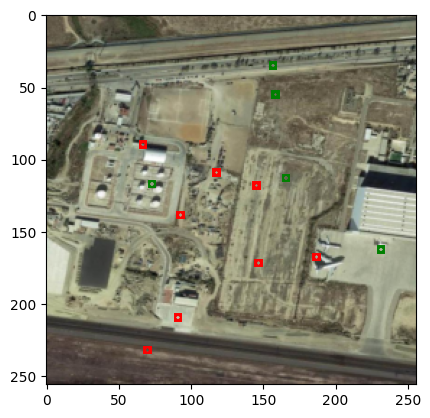

In [87]:
plot_centers(7, pred_boxes, target_boxes)

In red predicted, green true

In [73]:
sample = torch.rand(1, 3, 256, 256).to(DEVICE)
model.eval()
output = model(sample)
print(output.shape)

torch.Size([1, 441])


In [75]:

# Set the path to save the ONNX model
onnx_model_path = "fomo.onnx"

# Export the model to ONNX format
torch.onnx.export(model, sample, onnx_model_path)


# PYHELAYERS

## Select a subset of plain samples from test set

In [18]:
test_img_list=[]
test_label_list=[]
for values in test_dataset:
    image = values[0]
    label = values[1]
    test_img_list.append(image)
    test_label_list.append(label)
    if len(test_img_list)==1:
        break

test_img_array = np.array(test_img_list)
test_label_array = np.array(test_label_list)
# test_img_array = test_img_array[:11728]
# test_label_array = test_label_array[:11728]
# test_img_array = test_img_array.reshape(733,16,3,64,64)
# test_label_array = test_label_array.reshape(733,16,7,7,30)
print(test_img_array.shape)
print(test_label_array.shape)

(1, 3, 256, 256)
(1, 7, 7, 9)


## Initialize he scheme

In [21]:
import pyhelayers
import utilshe

utilshe.verify_memory()

print('Misc. initalizations')

Misc. initalizations


In [22]:
context = pyhelayers.DefaultContext()
print('HE context ready')

HE context ready


In [23]:

nnp = pyhelayers.NeuralNetPlain()

In [24]:
hyper_params = pyhelayers.PlainModelHyperParams()
nnp.init_from_files(hyper_params, ["fomo.onnx"])


In [25]:
he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(1)

profile = pyhelayers.HeModel.compile(nnp, he_run_req)
batch_size = profile.get_optimal_batch_size()
print('Profile ready. Batch size=',batch_size)

Profile ready. Batch size= 1


In [26]:
profile.get_he_config_requirement()

He configuration requirement:
Security level: 128
Integer part precision: 10
Fractional part precision: 50
Number of slots: 16384
Multiplication depth: 11
Bootstrappable: False
Automatic bootstrapping: False
Rotation keys policy: custom, 26 keys required:
[-2048, -1024, -512, -256, -128, -64, -32, -16, -8, -4, -2, -1, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [ ]:
context = pyhelayers.HeModel.create_context(profile)
print('HE context initalized')

In [ ]:
context.get_scheme_name()

In [ ]:
context.get_default_scale()

In [ ]:
# context.get_library_name()

In [ ]:
# context.has_secret_key()

In [ ]:
# context.save_secret_key_to_file('secret_key.txt')

In [ ]:
nn = pyhelayers.NeuralNet(context)
nn.encode_encrypt(nnp, profile)
print('Encrypted network ready')

In [ ]:
plain_samples, labels = utilshe.extract_batch(test_img_array, test_label_array, batch_size, 0)

print('Batch of size',batch_size,'loaded')

In [ ]:
print(plain_samples.shape)
print(plain_samples.dtype)

In [ ]:
iop = nn.create_io_processor()
samples = pyhelayers.EncryptedData(context)
iop.encode_encrypt_inputs_for_predict(samples, [plain_samples])
print('Test data encrypted')

## Make prediction on encrypted data

In [ ]:
utilshe.start_timer()

predictions = pyhelayers.EncryptedData(context)
nn.predict(predictions, samples)

duration=utilshe.end_timer('predict')
utilshe.report_duration('predict per sample',duration/batch_size)

In [ ]:
plain_predictions_aHE = iop.decrypt_decode_output(predictions)
print(f"plain prediction shape after HE: {plain_predictions_aHE.shape}")

In [ ]:
type(plain_predictions_aHE)

In [ ]:
# ## In case I have test samples > batch size
# plain_predictions_aHE = plain_predictions_aHE.reshape(,1470)

## Evaluate prediction with HE

In [ ]:
plain_predictions_bHE=[]
for sample in test_img_array:
    tensor_sample = torch.tensor(sample).unsqueeze(0)
    output = model(tensor_sample)
    output = output.detach().numpy()
    plain_predictions_bHE.append(output)
plain_predictions_bHE = np.array(plain_predictions_bHE)
plain_predictions_bHE = plain_predictions_bHE.reshape(1, 441)
print(f"plain prediction shape before HE: {plain_predictions_bHE.shape}")


In [ ]:

# Compute the absolute differences between plain prediction before and after HE
differences = np.abs(plain_predictions_bHE - plain_predictions_aHE)

# Compute relevant statistics
mean_difference = np.mean(differences)
max_difference = np.max(differences)
min_difference = np.min(differences)
std_difference = np.std(differences)

print(f"Mean difference: {mean_difference}")
print(f"Max difference: {max_difference}")
print(f"Min difference: {min_difference}")
print(f"Std difference: {std_difference}")


### Convert prediction in bounding boxes

In [ ]:
def get_bboxes_from_prediction(
    predictions,
    test_image_array,
    iou_threshold,
    threshold,
):
    all_pred_boxes = []

    
    train_idx = 0

    bboxes = cellboxes_to_boxes(predictions)

    for idx in range(len(test_image_array)):
        image = test_image_array[idx]

        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
        )

        # Activate only for test
        if  idx == 0:
            plot_image(image.permute(1,2,0).to("cpu"), nms_boxes)

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        

        train_idx += 1

    return all_pred_boxes


In [ ]:
tensor_predaHE = torch.tensor(plain_predictions_aHE)
tensor_predbHE = torch.tensor(plain_predictions_bHE)
tensor_imgs = torch.tensor(test_img_array)

print("Prediction before HE")
bboxes_aHE = get_bboxes_from_prediction(tensor_predbHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)

print("Prediction after HE")
bboxes_bHE = get_bboxes_from_prediction(tensor_predaHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)